In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
import numpy as np

from numba import jit, prange

@jit(nopython=True, parallel=True)
def convert_images(ds_full: np.ndarray):
    images = np.empty((len(ds_full), 100, 100), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i].numpy()
        img = Image.fromarray(img)
        img = img.resize((100, 100))
        img = img.convert('L')
        images[i] = np.array(img)
    
    return images

def load_data(size=100, lim=100, use_jit=False):
    import deeplake

    # Load the FFHQ dataset
    ds = deeplake.load("hub://activeloop/ffhq")

    ds_full = ds['images_1024']['image'][:lim].numpy()

    if use_jit:
        images = convert_images(ds_full)
        return images

    images = np.empty((len(ds_full), size, size), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i]
        img = Image.fromarray(img)
        img = img.resize((size, size))
        img = img.convert('L')
        images[i] = np.array(img)

    return images


In [3]:
BASE_OUTPUT_FOLDER = os.path.join('results', 'q4')

In [4]:
size_img = 100
X = load_data(size=size_img, lim=8)
# num_samples, img_height, img_width = X.shape
# X = X.reshape(num_samples, img_height * img_width)
print(f"Image max: {X.max()}, Image min: {X.min()}")
X = X / X.max()

/home/mauro/miniconda3/envs/disciplinas/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/ffhq loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ffhq
Image max: 255, Image min: 0


In [5]:
I = X.copy()
print(I.shape)

(8, 100, 100)


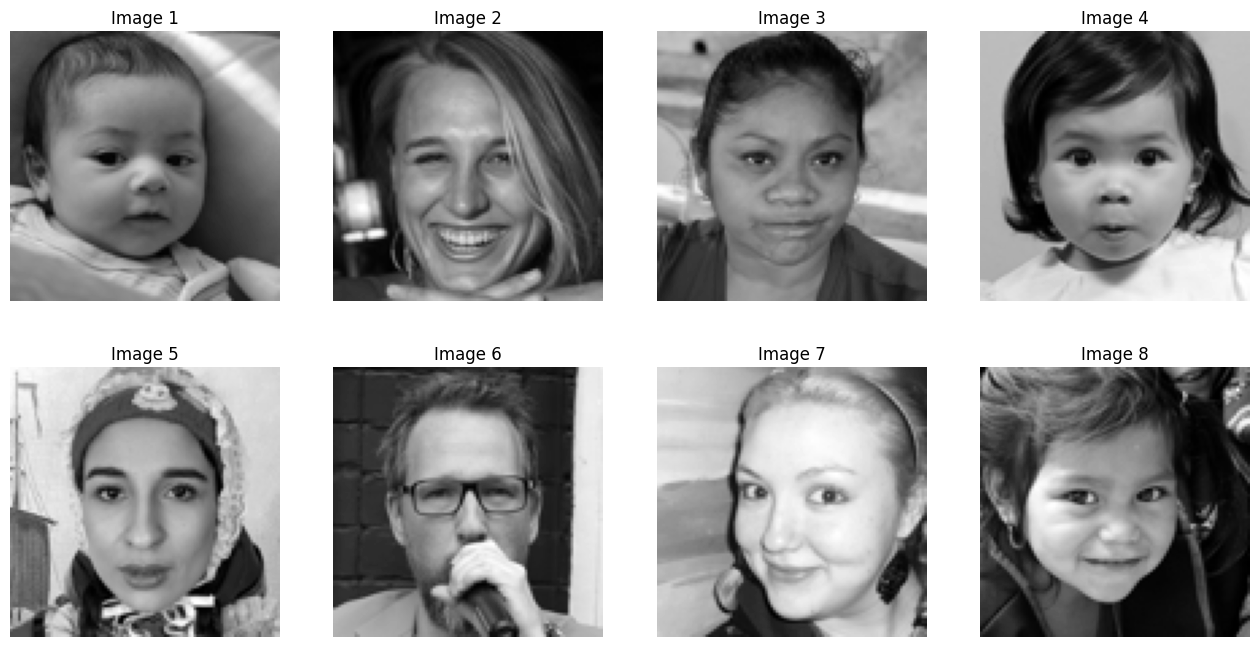

In [35]:
plt.figure(figsize=(16, 8))

for i, img in enumerate(I):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'img_{i}.png'))
plt.show()

In [ ]:
from scipy.fftpack import dst, idst
def compute_dst(image):
    return dst(dst(image.T, type=2, norm='ortho').T, type=2, norm='ortho')

# Compute DST and absolute values
V = [compute_dst(img) for img in I]
L_abs = [np.abs(V_i) for V_i in V]

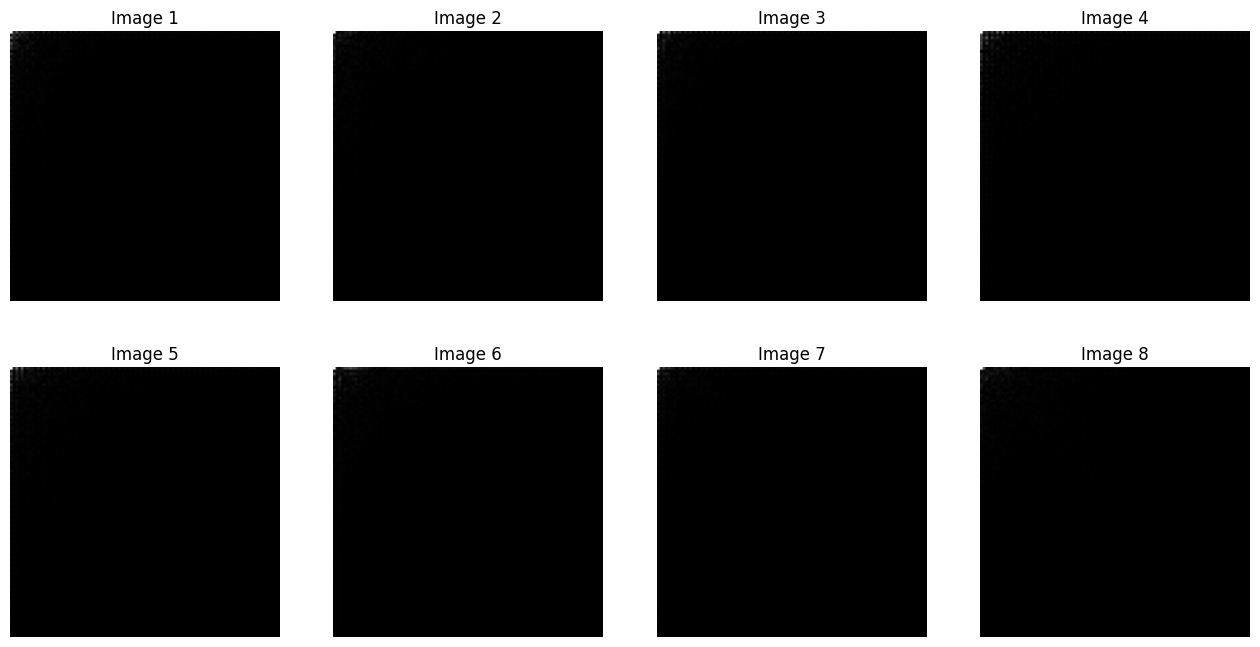

In [ ]:
plt.figure(figsize=(16, 8))

for i, img in enumerate(L_abs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'img_dst_{i}.png'))
plt.show()

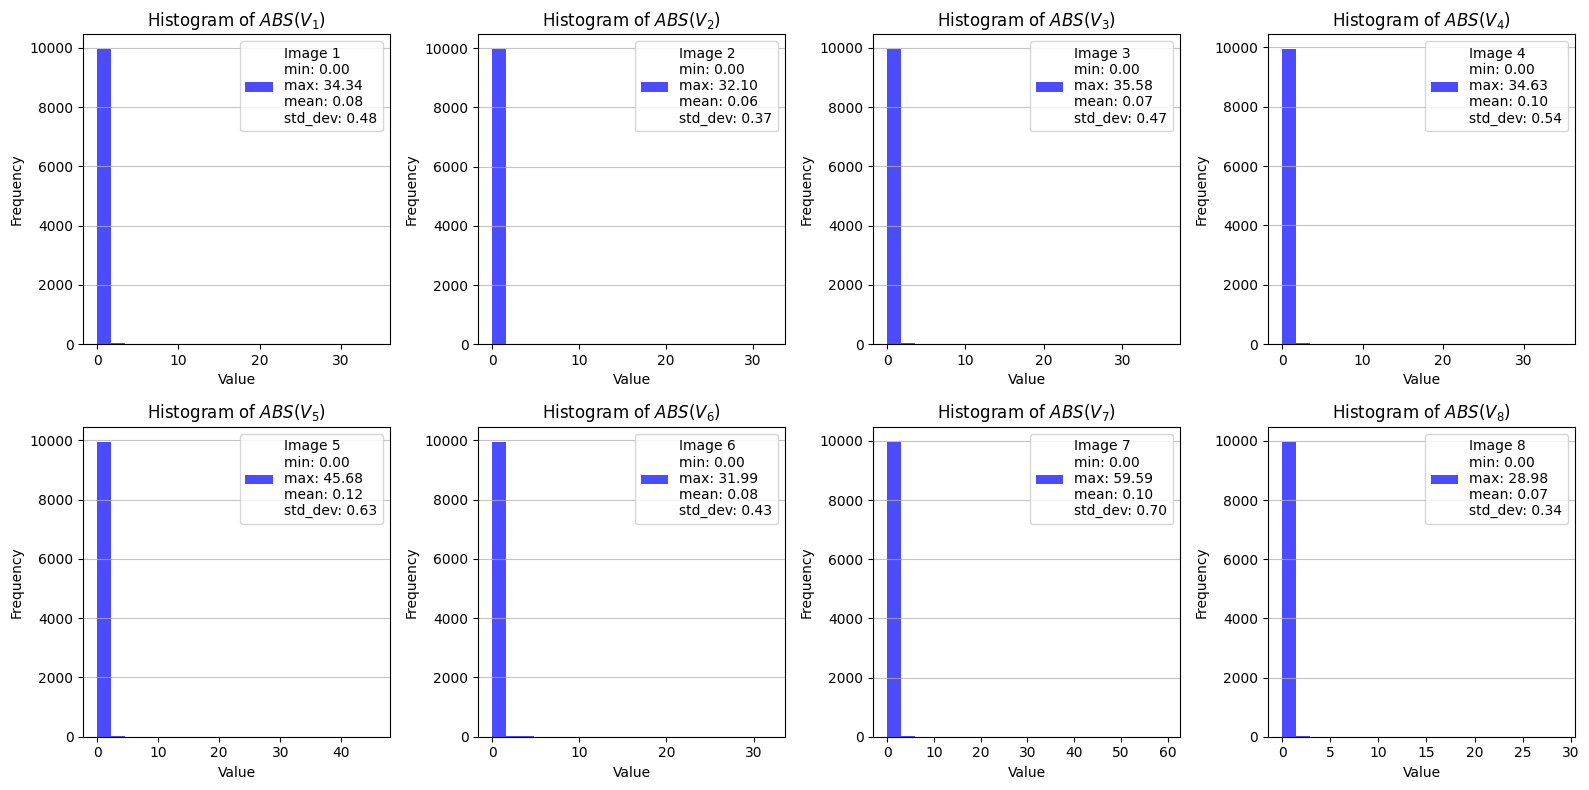

In [21]:
import matplotlib.pyplot as plt

features = {
    "min": [np.min(abs_img) for abs_img in L_abs],
    "max": [np.max(abs_img) for abs_img in L_abs],
    "mean": [np.mean(abs_img) for abs_img in L_abs],
    "std_dev": [np.std(abs_img) for abs_img in L_abs],
    "histogram": [np.histogram(abs_img, bins=10) for abs_img in L_abs],  # Example: 10 bins
}

plt.figure(figsize=(16, 8))
for i, abs_img in enumerate(L_abs):
    # print(f"Image {i+1} Statistics:")
    # print(f"Min: {features['min'][i]}")
    # print(f"Max: {features['max'][i]}")
    # print(f"Mean: {features['mean'][i]}")
    # print(f"Std Dev: {features['std_dev'][i]}")

    plt.subplot(2, 4, i + 1)
    plt.hist(abs_img.ravel(), bins=20, color='blue', alpha=0.7, label=f"Image {i+1}\nmin: {features['min'][i]:.2f}\nmax: {features['max'][i]:.2f}\nmean: {features['mean'][i]:.2f}\nstd_dev: {features['std_dev'][i]:.2f}")
    plt.title(f"Histogram of $ABS(V_{i+1})$")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, 'histograms_abs_vi.png'), bbox_inches='tight')
plt.show()


# Dimensionality Reduction

In [37]:
np.array(V).shape

(8, 100, 100)

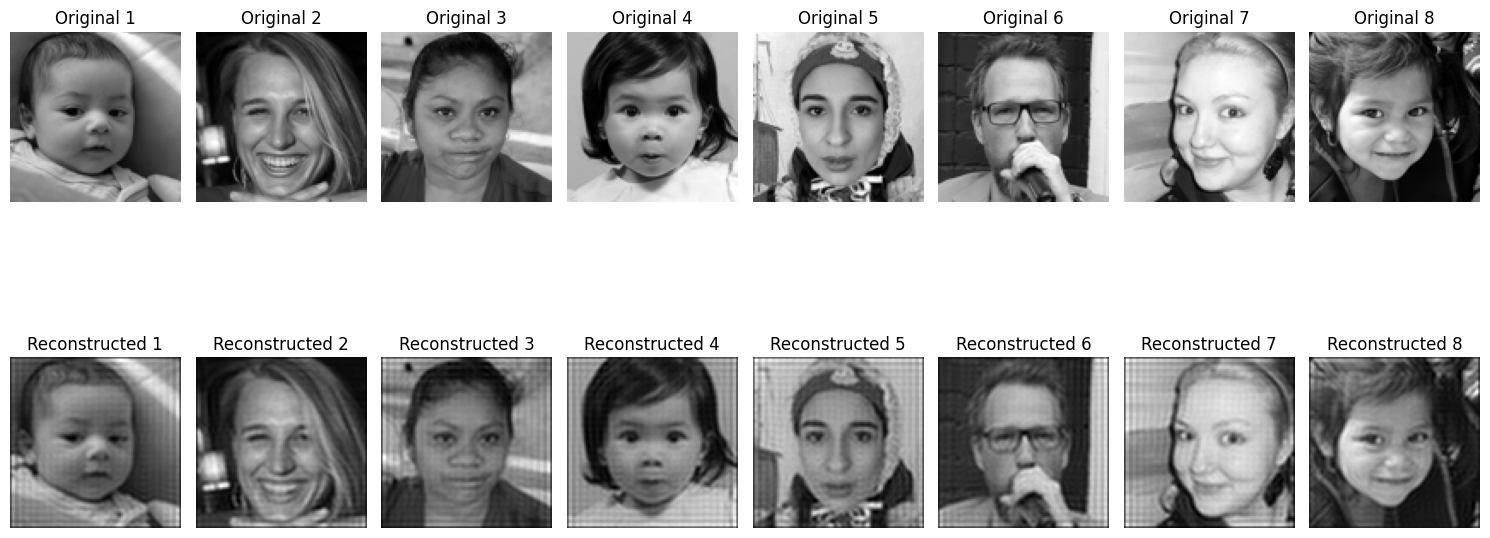

In [50]:
def truncate_dst(dst_image, num_coefficients):
    mask = np.zeros_like(dst_image)
    mask[:num_coefficients, :num_coefficients] = 1
    return dst_image * mask

num_coefficients = 50 # int(np.sqrt(380))
reconstructed_images = []

for V_i in V:
    V_truncated = truncate_dst(V_i, num_coefficients)
    reconstructed = idst(idst(V_truncated.T, type=2, norm='ortho').T, type=2, norm='ortho')
    reconstructed_images.append(reconstructed)

plt.figure(figsize=(15, 8))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(I[i], cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(2, 8, i+9)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'dst_reconstruction_n_components_{num_coefficients}.png'), bbox_inches='tight')
plt.show()